# Analyzing TS Albums by Lyric Usage

## Pulling every song on each album released by TS

In [1]:
# import packages
import spotipy as spt
import sys
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
from datetime import datetime
import re

In order to access the Spotify API, we must create credentials through their site.

In [2]:
# spotify api login credentials
client_id = ''
client_secret = ''

We use Spotipy to access the API and pull data from Spotify.

In [3]:
# spotify api login
client_credentials_manager = SpotifyClientCredentials(client_id,client_secret)
sp = spt.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
# pulling taylor details based on her uri
taylor_swift = sp.artist("06HL4z0CvFAxyc27GXpf02")

In [5]:
# pulling taylor album details

# can only pull 50 albums at a time and taylor has >50, so we need 2 pulls
taylor_albums1 = sp.artist_albums(taylor_swift['id'], album_type='album', limit=50, offset=0) # pull albums 0-49
taylor_albums2 = sp.artist_albums(taylor_swift['id'], album_type='album', limit=50, offset=50) # pull albums 50-end

In [6]:
# turning taylor album info into pandas dataframes and concatenating together into one
taylor_albums1_pd = pd.DataFrame(data=taylor_albums1['items'])
taylor_albums2_pd = pd.DataFrame(data=taylor_albums2['items'])
taylor_album_pd = pd.concat([taylor_albums1_pd, taylor_albums2_pd])

In [7]:
print('number of TS albums as of',datetime.now(),':',len(taylor_album_pd))

number of TS albums as of 2023-02-01 13:23:32.619311 : 68


We initialize a dictionary that includes every distinct album released by Taylor Swift.

In [8]:
# dictionary with album name (key), uri (value)
# we are using a groupby to remove duplicate album titles and taking only one uri for each
taylor_album_dict = taylor_album_pd[['name','uri']].groupby(['name'])['uri'].max().to_dict()

We use the Spotipy album_tracks() function to pull in all songs for each album.

In [9]:
# dictionary with album name, all song names
taylor_song_dict = defaultdict(list)
for album_name in taylor_album_dict.keys():
    album_uri = taylor_album_dict[album_name]
    tracks = sp.album_tracks(album_uri)['items']
    for track in tracks:
        track_name = track['name']
        track_id = track['id']
        taylor_song_dict[album_name].append(track_name)

We now see a dictionary with keys as album titles, values as all songs on that album.

In [10]:
taylor_song_dict['Lover']

['I Forgot That You Existed',
 'Cruel Summer',
 'Lover',
 'The Man',
 'The Archer',
 'I Think He Knows',
 'Miss Americana & The Heartbreak Prince',
 'Paper Rings',
 'Cornelia Street',
 'Death By A Thousand Cuts',
 'London Boy',
 'Soon You’ll Get Better (feat. The Chicks)',
 'False God',
 'You Need To Calm Down',
 'Afterglow',
 'ME! (feat. Brendon Urie of Panic! At The Disco)',
 'It’s Nice To Have A Friend',
 'Daylight']

## Cleaning song titles in order to prep for webscraping

In [11]:
taylor_song_dict_clean = defaultdict(list)
for album_name in taylor_song_dict.keys():
    for song_name in taylor_song_dict[album_name]:

# to pull from azlyrics, title must remove all non-alphabnumeric characters and any features
# however, include TV, FTV
# "no body, no crime (feat. HAIM)" becomes "nobodynocrime"
# "The Very First Night (Taylor's Version) (From The Vault)" becomes "theveryfirstnighttaylorsversionfromthevault"

        taylor_song_dict_clean[album_name].append(re.sub('[^A-Za-z0-9]+', '', song_name.lower().split('feat')[0]))

We have now removed features, spaces, and non-alphanumeric characters from our song titles.

In [12]:
# we see that we have removed features
taylor_song_dict_clean['Lover']

['iforgotthatyouexisted',
 'cruelsummer',
 'lover',
 'theman',
 'thearcher',
 'ithinkheknows',
 'missamericanatheheartbreakprince',
 'paperrings',
 'corneliastreet',
 'deathbyathousandcuts',
 'londonboy',
 'soonyoullgetbetter',
 'falsegod',
 'youneedtocalmdown',
 'afterglow',
 'me',
 'itsnicetohaveafriend',
 'daylight']

However, we see a huge number of albums, many of which are versions of one another, which will likely show only small changes in lyricism. We want to cut down to only the "main" albums.

In [14]:
# taylor has a lot of versions of albums! 
# we will cut down to the basics: remove all deluxe, commentary, karaoke, etc.
# if (Taylor's Version) exists, we will take that
prohibited_list = ['karaoke','live','deluxe','special','version','edition','tour']

basic_taylor_album_list = []
for album_name in taylor_song_dict_clean.keys():
    if album_name+' (Taylor\'s Version)' in taylor_song_dict_clean.keys():
        basic_taylor_album_list.append(album_name+' (Taylor\'s Version)') # take TV and not original
    elif any(x in album_name.lower() for x in prohibited_list): # lower since she alternates cases in albums
        pass # do not append if prohibited terms included
    else:
        basic_taylor_album_list.append(album_name) # other original albums can be included
        
print(basic_taylor_album_list)

['1989', "Fearless (Taylor's Version)", 'Lover', 'Midnights', "Red (Taylor's Version)", 'Speak Now', 'Taylor Swift', 'evermore', 'folklore', 'reputation']


In [15]:
# create dictionary with song titles for just our identified albums
for album_name in taylor_song_dict.keys():
    if album_name not in basic_taylor_album_list:
        del taylor_song_dict_clean[album_name]

## Webscrape AZLyrics

We use AZLyrics in order to pull lyrics for each song.

In [13]:
from bs4 import BeautifulSoup
import requests

In [25]:
# automatic webscraping of AZLyrics pages using BeautifulSoup
taylor_album_lyrics_dirty = defaultdict(list)
for album_name in basic_taylor_album_list:
    for song_name in taylor_song_dict_clean[album_name]:
        page = requests.get("https://www.azlyrics.com/lyrics/taylorswift/"+song_name+".html")
        soup = BeautifulSoup(page.content,'html.parser')
        if str(page) == '<Response [200]>': # ensure we are not being denied access
            taylor_album_lyrics_dirty[album_name].append(soup)

In [26]:
# check if we were denied access
# if a few albums are off by only 1 or 2 songs, likely because title doesn't follow azlyrics format
for album_name in taylor_song_dict_clean.keys():
    if len(taylor_album_lyrics_dirty[album_name]) == len(taylor_song_dict_clean[album_name]):
        print('Success for',album_name,'- number of tracks:',len(taylor_album_lyrics_dirty[album_name]))
    else:
        print('Fail for',album_name,'- number of tracks missing:',len(taylor_song_dict_clean[album_name])-len(taylor_album_lyrics_dirty[album_name]))
        

Success for 1989 - number of tracks: 13
Success for Fearless (Taylor's Version) - number of tracks: 26
Success for Lover - number of tracks: 18
Success for Midnights - number of tracks: 13
Fail for Red (Taylor's Version) - number of tracks missing: 2
Fail for Speak Now - number of tracks missing: 1
Fail for Taylor Swift - number of tracks missing: 2
Success for evermore - number of tracks: 15
Success for folklore - number of tracks: 16
Success for reputation - number of tracks: 15


In [27]:
taylor_album_lyrics_clean = defaultdict(list)
for album_name in taylor_album_lyrics_dirty.keys():
    for lyrics in taylor_album_lyrics_dirty[album_name]:
        taylor_album_lyrics_clean[album_name].append(str(lyrics).split('<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->')[1].split('<!-- MxM banner -->')[0].replace('<br/>','').replace('</div>','').split())

In [29]:
# cleaning the words and removing them from their sublists
taylor_album_lyrics = defaultdict(list)
for album_name in taylor_album_lyrics_clean.keys():
    for line in taylor_album_lyrics_clean[album_name]:
        for word in line:
            taylor_album_lyrics[album_name].append(re.sub('[^A-Za-z0-9\']+', '', word.lower()))

## Writing dictionary into individual .txt files
This is the input the wordcloud package takes

In [30]:
for album_name in taylor_album_lyrics.keys():
    with open(album_name+'.txt', 'w') as f:
        for word in taylor_album_lyrics[album_name]:
            print(word, file=f)

## Creating wordclouds

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [32]:
def wordclouding(album_name):
    # open each text file with corresponding lyrics
    text = open(album_name+'.txt').read()
    # each album cover has been saved as 'album_name.png', here we open them as numpy array
    coloring = np.array(Image.open(album_name+'.png'))
    
    # set words that won't be included in the cloud
    stop_words = ['oh','ohoh'] + list(STOPWORDS)
    
    # generate word cloud
    wc = WordCloud(background_color="white", max_words=2000, relative_scaling=0.4, mask=coloring,
               collocations=False,stopwords=stop_words, max_font_size=25, random_state=42,include_numbers=True)
    wc.generate(text)

    # generate image with colors that match its original form
    image_colors = ImageColorGenerator(coloring)
    fig, axes = plt.subplots(1, 2)
    #axes[0].imshow(wc, interpolation="bilinear")
    axes[0].imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    axes[1].imshow(coloring, cmap=plt.cm.gray, interpolation="bilinear")
    # show final plot
    for ax in axes:
        ax.set_axis_off()
    plt.show()

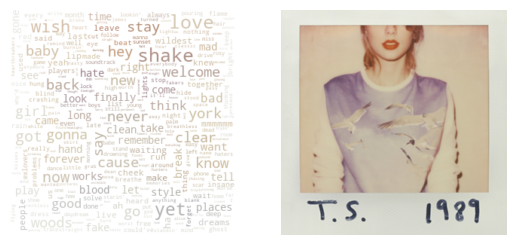

1989 None


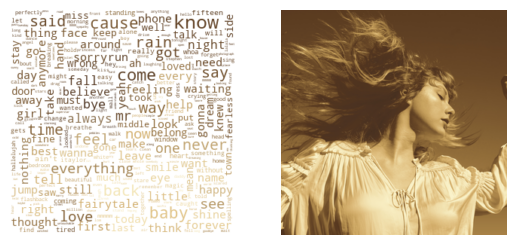

Fearless (Taylor's Version) None


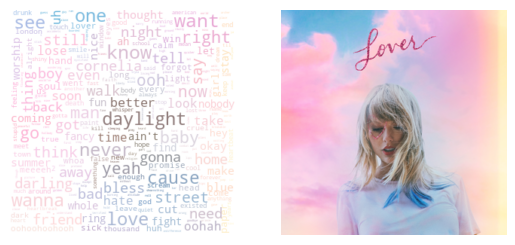

Lover None


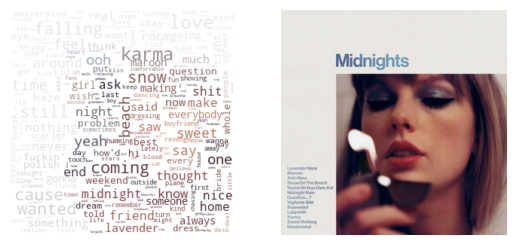

Midnights None


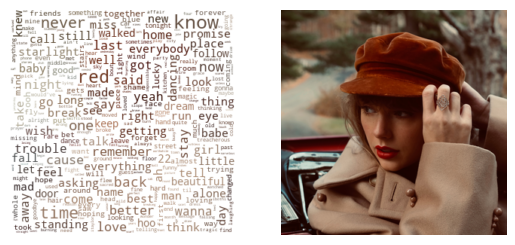

Red (Taylor's Version) None


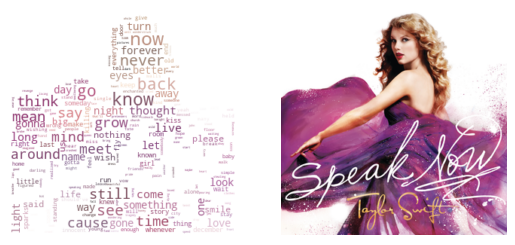

Speak Now None


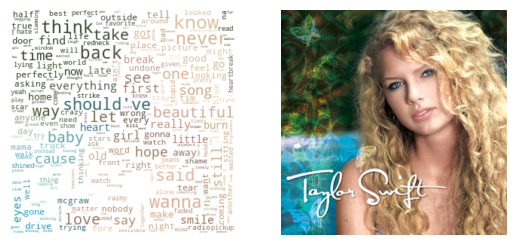

Taylor Swift None


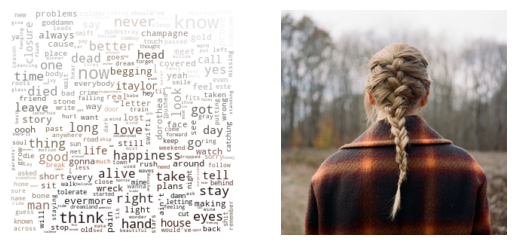

evermore None


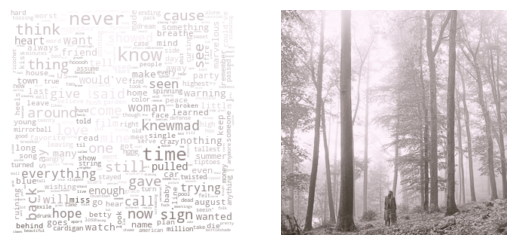

folklore None


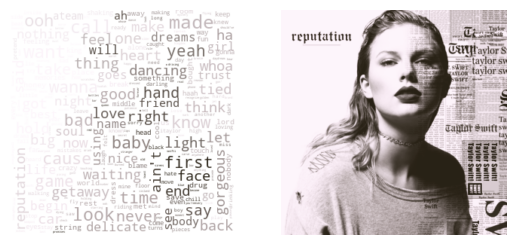

reputation None


In [33]:
for album_name in taylor_album_lyrics.keys():
    print(album_name,wordclouding(album_name))